In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import json
import random

## Data Preparation & Preprocessing

In [151]:
# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [152]:
# Load the data
def load_data(file):
    # Load the data
    data = pd.read_csv('data/' + file + '.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # round to 2 decimal places
    data = data.round(2) 

    return data

data = load_data('SP500')

In [153]:
# Preprocess the data (using min-max scaler)
def normalize(features):
    min_val = np.min(features)
    max_val = np.max(features)
    return (features - min_val) / (max_val - min_val)
    
features = np.array(data[['Close']])
scaled_data = normalize(features)

In [154]:
# Load hyperparameters
with open('configs/configs.json', 'r') as file:
    hyperparams = json.load(file)

In [155]:
# Create sequences
def create_sequences(data, input_size, num_steps):
    data = [np.array(data[i * input_size: (i + 1) * input_size]) 
       for i in range(len(data) // input_size)]

    # Split into groups of `num_steps`
    X = np.array([data[i: i + num_steps] for i in range(len(data) - num_steps)])
    y = np.array([data[i + num_steps] for i in range(len(data) - num_steps)])
    
    return X, y

num_steps = hyperparams['num_steps'] # Extract number of steps
input_size = hyperparams['input_size'] # Extract number of steps
test_split = hyperparams['test_split']
X, y = create_sequences(scaled_data, input_size, num_steps)

split = int((1 - test_split) * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## LSTM

In [156]:
# Extract hyperparameters
def extract_hyperparams(hyperparams, model):
    num_units = hyperparams[model][model + '_units']
    num_layers = hyperparams[model][model + '_layers']
    dropout_rate = hyperparams[model]['dropout_rate']
    dense_units = hyperparams[model]['dense_units']
    batch_size = hyperparams[model]['batch_size']
    max_epochs = hyperparams[model]['max_epochs']
    use_early_stop = hyperparams[model]['use_early_stop']
    early_stop_patience = hyperparams[model]['early_stop_patience']
    train_needed = hyperparams[model]['pretrain'] # Whether to train the model

    return num_units, num_layers, dropout_rate, dense_units, batch_size, epochs, use_early_stop, early_stop_patience, train_needed

num_units, num_layers, dropout_rate, dense_units, batch_size, max_epochs, use_early_stop, early_stop_patience, train_needed = extract_hyperparams(hyperparams, 'lstm')

In [157]:
def build_model(layer_type, 
                num_units, 
                num_layers, 
                dropout_rate, 
                dense_units, 
                train_needed):
    
    if train_needed: # Build model
        model = Sequential()

        if layer_type == 'lstm':
            layer = LSTM
        else: # GRU
            layer = GRU
        
        for i in range(num_layers):
            if i == 0:
                # Add the first LSTM layer with the input shape
                model.add(layer(units=num_units, return_sequences=True, input_shape=(num_steps, input_size)))
            elif i == num_layers - 1:
                # Add the last LSTM layer without return_sequences
                model.add(layer(units=num_units))
            else:
                # Add intermediate LSTM layers with return_sequences
                model.add(layer(units=num_units, return_sequences=True))
        
        model.add(Dropout(dropout_rate))
    
        model.add(Dense(dense_units))
        model.add(Dense(1))
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        
    else: # Load model
        model = load_model('models/SP500_' + layer_type + '_model.h5')
    
    print(model.summary())
    return model

model = build_model('lstm', 
                num_units, 
                num_layers, 
                dropout_rate, 
                dense_units, 
                train_needed)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 25)                3225      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 201395 (786.70 KB)
Trainable params: 201

In [158]:
def train_model(model,
                batch_size, 
                epochs, 
                use_early_stop, 
                early_stop_patience, 
                train_needed):
    # Train the model if needed
    if train_needed:
        if use_early_stop:
            early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
            history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_test, y_test), callbacks=[early_stop])
        else:
            history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_test, y_test))
        
        # Save model for future use
        model.save('models/SP500_LSTM_model.h5')
        
        # Evaluate the model 
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.show()

train_model(model,
            batch_size, 
            max_epochs, 
            use_early_stop, 
            early_stop_patience, 
            train_needed)

In [159]:
def make_predictions(num_steps, input_size):
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform predictions to the original scale
    predictions_rescaled = np.zeros_like(scaled_data)
    predictions_rescaled[:] = np.nan  # Fill the 'Close' column
    predictions_rescaled[split+(num_steps * input_size):] = predictions
    predictions_rescaled = scaler.inverse_transform(predictions_rescaled)
    
    # Extract actual close prices and ensure they're in the right shape for comparison
    actual_prices = scaled_data[split+(num_steps * input_size):]
    actual_prices_rescaled = scaler.inverse_transform(np.hstack((np.zeros((len(actual_prices), scaled_data.shape[1] - 1)), actual_prices.reshape(-1, 1))))
    actual_prices_rescaled = actual_prices_rescaled[:, -1]

    return predictions, actual_prices

predictions, actual_prices = make_predictions(num_steps, input_size)

2024-07-07 21:02:37.614027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-07 21:02:37.686586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-07 21:02:37.777943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 2s 20ms/step


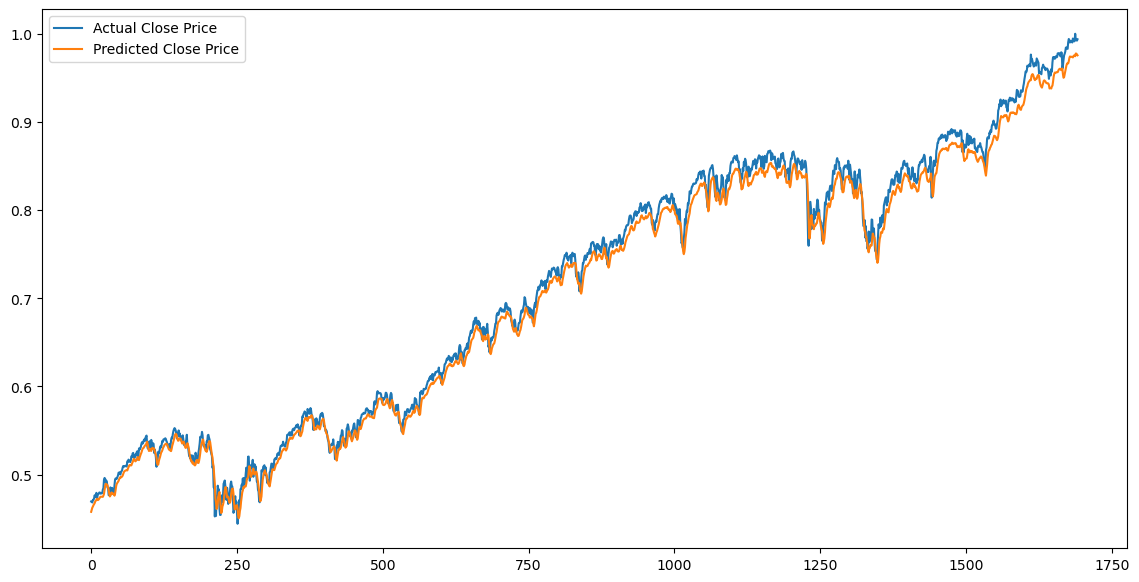

In [160]:
# Visualize the results
def visualize_results(actual_prices, predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, label='Actual Close Price')
    plt.plot(predictions[:, -1], label='Predicted Close Price')
    plt.legend()
    plt.show()

visualize_results(actual_prices, predictions)

In [161]:
def evaluate_model(actual_prices, predictions):
    # Final evaluation of model
    mse = mean_squared_error(actual_prices, predictions[:, -1])
    rmse = np.sqrt(mse)

    return mse, rmse

mse, rmse = evaluate_model(actual_prices, predictions)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 0.00016245759201567552
Root Mean Squared Error (RMSE): 0.012745885297446996


## GRU

In [162]:
# Extract hyperparameters
num_units, num_layers, dropout_rate, dense_units, batch_size, max_epochs, use_early_stop, early_stop_patience, train_needed = extract_hyperparams(hyperparams, 'gru')

In [163]:
# Build the GRU model (or load the saved model)
model = build_model('gru', 
                num_units, 
                num_layers, 
                dropout_rate, 
                dense_units, 
                train_needed)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 128)           50304     
                                                                 
 dropout_5 (Dropout)         (None, 60, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 25)                3225      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 152627 (596.20 KB)
Trainable params: 152

In [164]:
# Train the model if needed, or otherwise load the model
train_model(model,
            batch_size, 
            max_epochs, 
            use_early_stop, 
            early_stop_patience, 
            train_needed)

In [165]:
# Make predictions
predictions, actual_prices = make_predictions(num_steps, input_size)

2024-07-07 21:02:54.548265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-07 21:02:54.643523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/53 [=>............................] - ETA: 0s 

2024-07-07 21:02:54.799916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 2s 18ms/step


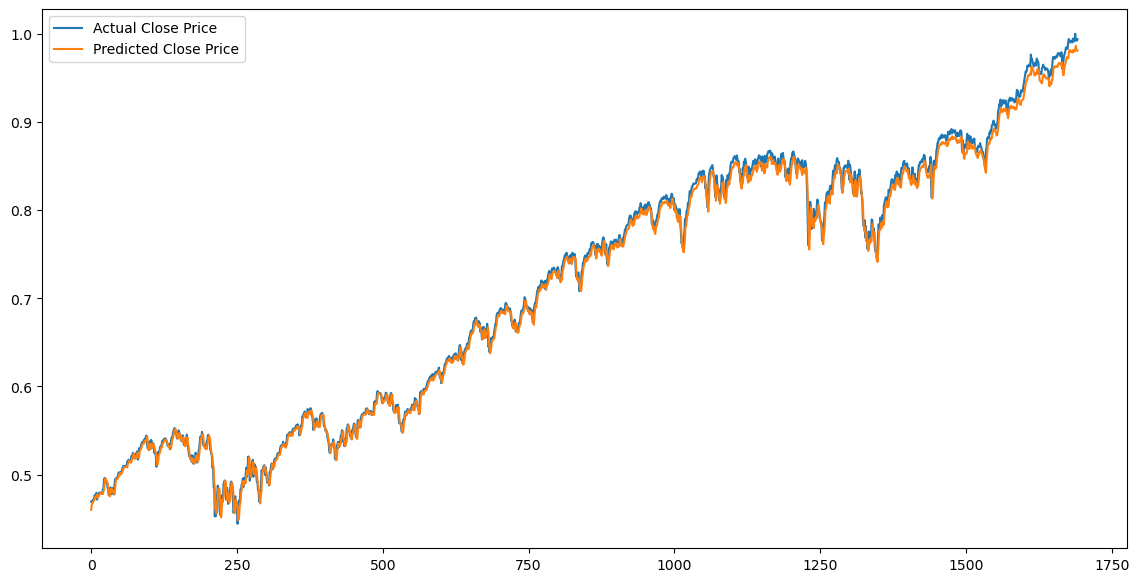

In [166]:
# Visualize the results
visualize_results(actual_prices, predictions)

In [167]:
# Final evaluation of model
mse, rmse = evaluate_model(actual_prices, predictions)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 6.767173462757235e-05
Root Mean Squared Error (RMSE): 0.008226283159943643
